포스터 이미지 배경화면처럼 바꾸기 VAE





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    losses,
    optimizers,
)

from scipy.stats import norm
import pandas as pd

In [ ]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 64 # 복잡하거나 성능을 높이고 싶을때(128,256... 높이기, 시간 오래걸림)
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 10
BETA = 2000
LOAD_MODEL = False

Kaggle 부분은 이미 다운로드 해서 이제 필요없음

In [ ]:
#!pip install kaggle

In [ ]:
#from google.colab import files
#files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sungshindatascience","key":"74705fe8022b0cfc8554e688a320995e"}'}

In [ ]:
#!mkdir ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# celeba 데이터셋을 다운로드
#!kaggle datasets download -d kimbosoek/cosmos-images

#!mkdir -p /content/drive/MyDrive/Colab\ Notebooks/2024_dev_generate

# 데이터를 해당 디렉토리에 압축 해제
#!unzip -q /content/cosmos-images.zip -d /content/drive/MyDrive/Colab\ Notebooks/2024_dev_generate


Dataset URL: https://www.kaggle.com/datasets/kimbosoek/cosmos-images
License(s): CC0-1.0
 98% 102M/104M [00:02<00:00, 63.2MB/s] 
100% 104M/104M [00:02<00:00, 52.7MB/s]


In [ ]:
#ls

cosmos-images.zip  drive/  kaggle.json  sample_data/


In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/2024_dev_generate/data/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),  # 모델 입력 크기
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)
# 데이터 전처리 및 크기 조정 함수
def preprocess_and_resize(image):
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image, "float32") / 255.0
    return image

# 데이터 전처리 적용
train = train_data.map(lambda image: preprocess_and_resize(image))

# 데이터셋 확인
for images in train.take(1):
    print(f'Image batch shape: {images.shape}')



Found 3612 files.
Image batch shape: (128, 64, 64, 3)


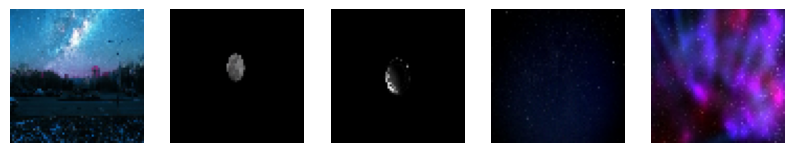

In [ ]:
# 이미지 일부를 출력하는 함수
def display_sample_images(dataset, num_images=5):
    plt.figure(figsize=(10, 10))
    for images in dataset.take(1):  # 첫 번째 배치만 가져오기
        for j in range(min(num_images, images.shape[0])):
            ax = plt.subplot(1, num_images, j + 1)
            plt.imshow(images[j])
            plt.axis("off")
    plt.show()

# 이미지 출력
display_sample_images(train)

In [ ]:
# 생성된 잠재공간에서 새로운 이미지를 추출할때 사용할 값
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# 인코더
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(
    encoder_input
)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

shape_before_flattening = K.int_shape(x)[1:]  # 디코더에 필요
x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 64)     │          1,792 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 32, 32, 64)     │            256 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_11            │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 64)     │         36,928 │ leaky_re_lu_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 16, 16, 64)     │            256 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_12            │ (None, 16, 16, 64)     │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 8, 8, 64)       │         36,928 │ leaky_re_lu_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 8, 8, 64)       │            256 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_13            │ (None, 8, 8, 64)       │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 4, 4, 64)       │         36,928 │ leaky_re_lu_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 4, 4, 64)       │            256 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_14            │ (None, 4, 4, 64)       │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 2, 2, 64)       │         36,928 │ leaky_re_lu_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 2, 2, 64)       │            256 │ conv2d_9[0][0]         │
│ (BatchNormalization) 

 Total params: 253,584 (990.56 KB)

 Trainable params: 252,944 (988.06 KB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
# 디코더
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
decoder_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          51,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_16 (LeakyReLU)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 4, 4, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_17 (LeakyReLU)           │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_18 (LeakyReLU)           │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_19 (LeakyReLU)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_9 (Conv2DTranspose) │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_20 (LeakyReLU)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_10                  │ (None, 64, 64, 64)          │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 240,131 (938.01 KB)

 Trainable params: 238,979 (933.51 KB)

 Non-trainable params: 1,152 (4.50 KB)

In [ ]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")
        self.mse_loss = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(
                BETA * self.mse_loss(data, reconstruction)
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA * self.mse_loss(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def get_config(self):
        return {}

In [ ]:
# 변이형 오토인코더 생성
vae = VAE(encoder, decoder)

In [ ]:
# 변이형 오토인코더 컴파일
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [ ]:
# 모델 저장 체크포인트 생성
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath = "/content/drive/MyDrive/Colab Notebooks/2024_dev_generate/test1/checkpoint.keras",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            img.save("/content/drive/MyDrive/Colab Notebooks/2024_dev_generate/test1/generated_img_%03d_%d.png" % (epoch, i))

In [ ]:
# 필요한 경우 이전 가중치 로드
if LOAD_MODEL:
    vae.load_weights("/content/drive/MyDrive/Colab Notebooks/2024_dev_generate/test1/models/vae")
    tmp = vae.predict(train.take(1))

In [ ]:
vae.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - kl_loss: 0.2414 - loss: 253.1176 - reconstruction_loss: 252.8763
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step - kl_loss: 3.1728 - loss: 113.0076 - reconstruction_loss: 109.8348
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - kl_loss: 3.8928 - loss: 82.8104 - reconstruction_loss: 78.9177
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - kl_loss: 4.2545 - loss: 72.9989 - reconstruction_loss: 68.7445
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 135s 4s/step - kl_loss: 5.9057 - loss: 65.9232 - reconstruction_loss: 60.0176
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - kl_loss: 6.8262 - loss: 62.1994 - reconstruction_loss: 55.3732
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step - kl_loss: 7.1639 - loss: 61.4529 - reconstruction_loss: 54.2890
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 115s 4s/step - kl_loss: 7.2689 - loss: 60.4976 - reconstruction_loss: 53.2288
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step - kl_loss: 7.2732

In [ ]:
# 최종 모델 저장

vae.save("/content/drive/MyDrive/Colab Notebooks/2024_dev_generate/test1/vae.keras")
encoder.save("/content/drive/MyDrive/Colab Notebooks/2024_dev_generate/test1/encoder.keras")
decoder.save("/content/drive/MyDrive/Colab Notebooks/2024_dev_generate/test1/decoder.keras")


In [ ]:
# 테스트 세트에서 일부분을 선택합니다.
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step
실제 사진 


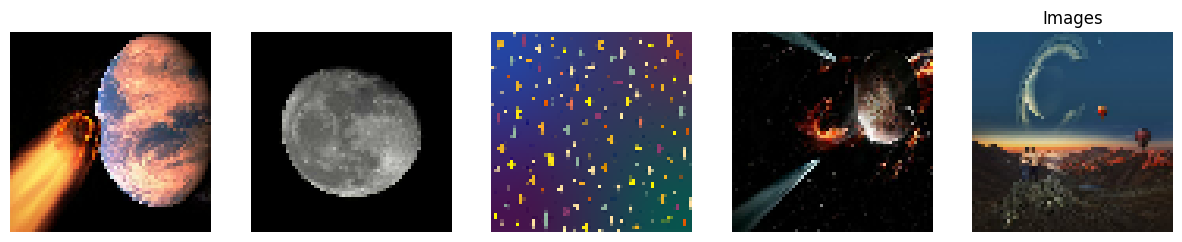

재구성


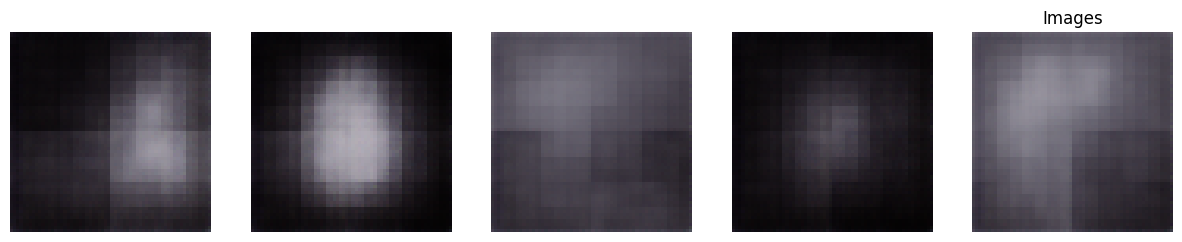

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def normalize_images(images):
    # 이미지 데이터를 [0, 1] 범위로 정규화
    images = (images - np.min(images)) / (np.max(images) - np.min(images))
    return images

def display_images(images, num_images=5, title="Images"):
    plt.figure(figsize=(15, 15))
    # 이미지 수가 num_images를 초과할 경우, num_images로 제한
    num_images = min(num_images, len(images))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.title(title)
    plt.show()

# 예측을 생성하고 출력합니다.
z_mean, z_log_var, reconstructions = vae.predict(example_images)
reconstructions = normalize_images(reconstructions)  # 범위 조정
example_images = normalize_images(example_images)  # 범위 조정

print("실제 사진 ")
display_images(example_images, num_images=5)
print("재구성")
display_images(reconstructions, num_images=5)

In [ ]:
# 표준 정규 분포에서 잠재 공간의 일부 포인트를 샘플링합니다.
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [ ]:
# 샘플링된 포인트 디코딩
reconstructions = decoder.predict(z_sample)

In [ ]:
# 디코딩된 이미지의 그리기
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# 배경화 그리드 출력
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])